### LSTM RNN -  Predictive Analytics

In [7]:
%load_ext watermark

In [8]:
%watermark -a 'Durga' -v -d -p numpy,pandas,matplotlib,sklearn,pyculiarity,seaborn

Durga 2017-01-10 

CPython 2.7.12
IPython 5.1.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.3
sklearn 0.18.1
pyculiarity 0.0.2
seaborn 0.7.1


In [9]:
%matplotlib inline

# general libs
import time
import sys
import numpy as np
import pandas as pd
import math

#plotting libs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator, AutoDateLocator, DateFormatter

# date time libs
import datetime as dt
from datetime import timedelta
import statsmodels.api as sm 

# ml libs
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# CSS Fileb
from IPython.core.display import HTML
from IPython.display import Image

# Style Setting
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")

Using Theano backend.


In [10]:
# Notebook Style Setting
css = open('styles/style-table.css').read() + open('styles/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

### Overview

### APIs...

In [11]:
##### DATA API ###########

def read_metric_data(csv_name):
    '''
        Read data from a given csv file.
        CSV format: [server_name, timestamp, value]
        Timestamp format: YYYY-MM-DD HH:mm:SS
        Lines begining with # are ignored as comments.
    '''
    # Read from csv file.
    df = pd.read_csv(csv_name, index_col=1, parse_dates=True, names=[ 'server', 'value'], comment='#', quotechar="'", sep=",")
    if(df.isnull().value.any()): 
        #print ("{0} - missing data row count#: {1}".format(csv_name, np.count_nonzero(df1.isnull().values)))
        df = df.fillna(method='ffill', limit=2) # Fill last value upto two consequtive slots
    print("{0} --- #(rows:columns): {1}".format(csv_name, df.shape))
    return df

def rename_series(series, prefix='v'):
    s = series.unique()
    newS = pd.Series(np.arange(len(s), dtype=np.int))
    newS = newS.apply(lambda x:  prefix + str(x))
    d = dict(zip(s, newS))
    newSeries =series.map(d)
    return newSeries

def expand_df(df, ef=2, freq='D'):
    d = df.copy()
    d1 = pd.concat([df]*ef, ignore_index=True)
    d1.index = pd.date_range(df.index[0], periods=len(d1), freq=freq)
    return d1

### Data Load & Data Preprocessing

In [12]:
# Read capacity used metric
df_used1 = read_metric_data("data/kelsey-capused-d.csv")

# revise server values
df_used1.server = rename_series(df_used1.server, prefix="v")

# Preprocess Data
df_used1.loc[:,('value')] = (df_used1.value/(1024*1024*1024)).round(2)

# group data by server
g1 = df_used1.groupby('server')

#df.loc[:,'diff'] = df.value.diff()

data/kelsey-capused-d.csv --- #(rows:columns): (4156, 2)


#### Summary stats...

In [13]:
# expand data
vdf0 = expand_df(g1.get_group("v0"), ef=10, freq='D')
vdf8 = expand_df(g1.get_group("v8"), ef=10, freq='D')
vdf40 = expand_df(g1.get_group("v40"), ef=10, freq='D')

summary = pd.DataFrame()
summary['v0'] = vdf0.describe().value
summary['v8'] = vdf8.describe().value
summary['v40'] = vdf40.describe().value
summary = summary.drop("count", axis=0)
summary = summary.round(2)

note: Also look for dark colors in each colums


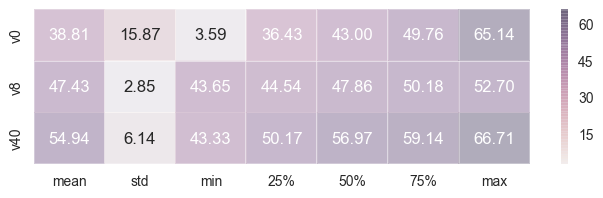

In [14]:
f, ax = plt.subplots(figsize=(8, 2))
sns.heatmap(summary.T, linewidths=.5, alpha=0.3, annot=True, fmt=".2f")
print("note: Also look for dark colors in each colums")

### Predictive Models

In [15]:
##### MODEL API ###########

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def build_model(layers):
    model = Sequential()

    model.add(LSTM(input_dim=layers[0], 
                   output_dim=layers[1], 
                   return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(layers[2], 
                   return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(output_dim=layers[3], 
                    activation='relu'))

    start = time.time()
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    print "Compilation Time : ", time.time() - start
    return model

def run_network(dataframe, layers = [1,50,100,1], lookback = 10, 
                   split_ratio=0.9, epochs=150, batch_size=10, seed=9):
    
    # fix random seed for reproducibility
    np.random.seed(seed)

    # load the dataset
    dataset = dataframe[[0]]
    dataset = dataset.astype('float32')

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # split into train and test sets
    train_size = int(len(dataset) * split_ratio)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # reshape into X=t and Y=t+1
    look_back = lookback + 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    print('Sequence: %s, trainX: %s, trainY: %s, testX: %s, testY: %s' 
          % (lookback, trainX.shape, trainY.shape, testX.shape, testY.shape))
    
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    #trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    #testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
        
    # create and fit the LSTM network
    model = build_model(layers)
    history = model.fit(trainX, trainY, nb_epoch=epochs, batch_size=batch_size, verbose=0)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('%s: Train_Score: %.2f RMSE, Test_Score: %.2f RMSE' % ("LSTM", trainScore, testScore))

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

    # Plot base lines & predictions
    fig = plt.figure(figsize=(12, 3))
    ax = plt.gca()
    plt.plot(scaler.inverse_transform(dataset), color='steelblue', linewidth=3, label='Original', alpha=0.7)
    plt.plot(trainPredictPlot, color='sage', label='TrainPredict')
    plt.plot(testPredictPlot, color='indianred', label='TestPredict')
    plt.xlabel("x", fontweight='bold')
    plt.ylabel("GB", fontweight='bold')
    plt.title("Baseline & Predictions")
    plt.legend(loc='best')
    
    return model, history

def plot_history(history):
    #Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
    g1 = sns.tsplot(history.history['mean_squared_error'], ax= axes)
    g1.set_ylabel("mean_squared_error", fontweight='bold', fontsize=12)
    g1.set_xlabel("epoch", fontweight='bold', fontsize=12)
    g1.set_title("Model Loss")
    return

Sequence: 10, trainX: (366L, 11L), trainY: (366L,), testX: (30L, 11L), testY: (30L,)
Compilation Time :  0.00600004196167
LSTM: Train_Score: 2.98 RMSE, Test_Score: 3.41 RMSE


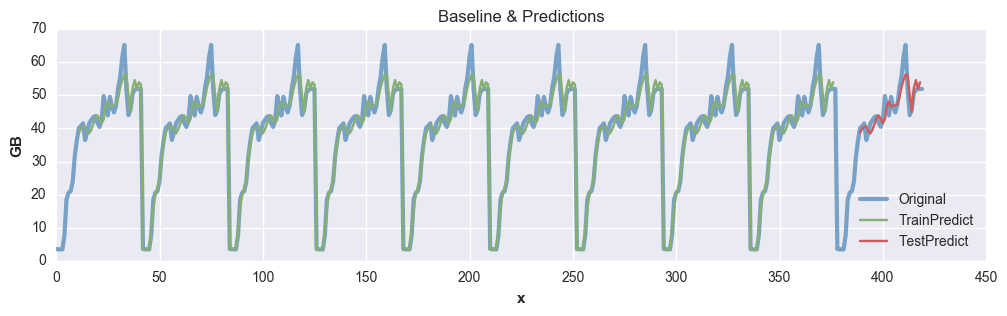

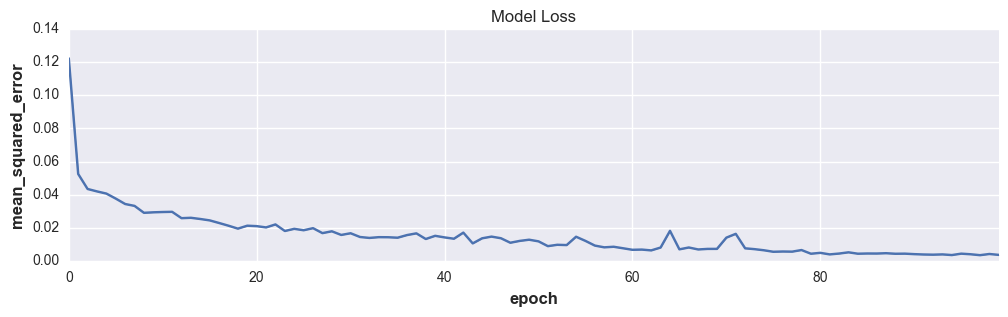

In [16]:
model, history = run_network(vdf0[['value']], layers = [1,50,100,1], 
                                lookback = 10, split_ratio=0.9, epochs=100)

plot_history(history)

Sequence: 10, testX: (1L, 10L), testY: (1L,)


In [173]:
df = pd.DataFrame(pds)
df

,0,1,2,3,4,5,6,7,8,9
0,0.797391,0.870186,0.666444,0.662182,0.768612,0.834135,0.87267,0.890563,0.89474,0.825678


Sequence: 10, trainX: (366L, 11L), trainY: (366L,), testX: (30L, 11L), testY: (30L,)
Compilation Time :  0.00399994850159
LSTM: Train_Score: 1.50 RMSE, Test_Score: 1.36 RMSE


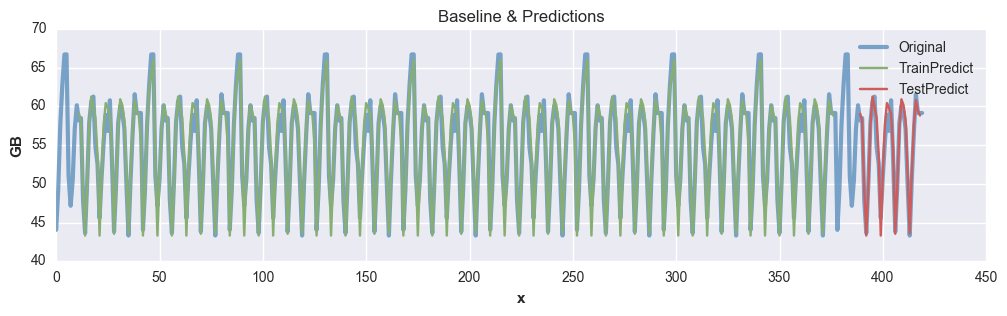

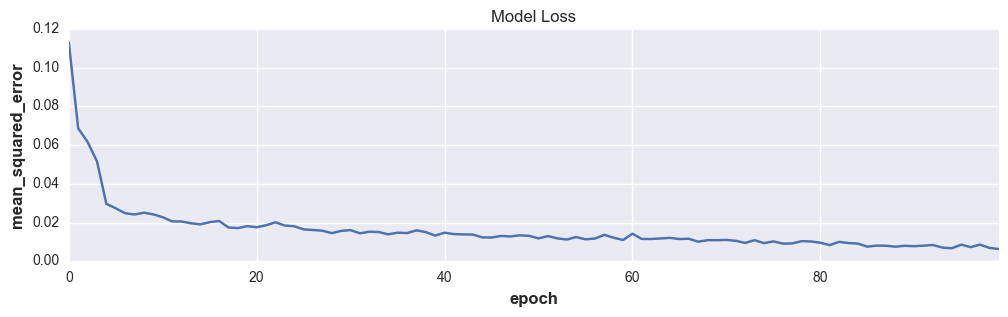

In [11]:
model, history = run_network(vdf40[['value']], layers = [1,50,100,1], 
                                lookback = 10, split_ratio=0.9, epochs=100)

plot_history(history)

Sequence: 10, trainX: (366L, 11L), trainY: (366L,), testX: (30L, 11L), testY: (30L,)
Compilation Time :  0.00500011444092
LSTM: Train_Score: 0.51 RMSE, Test_Score: 0.45 RMSE


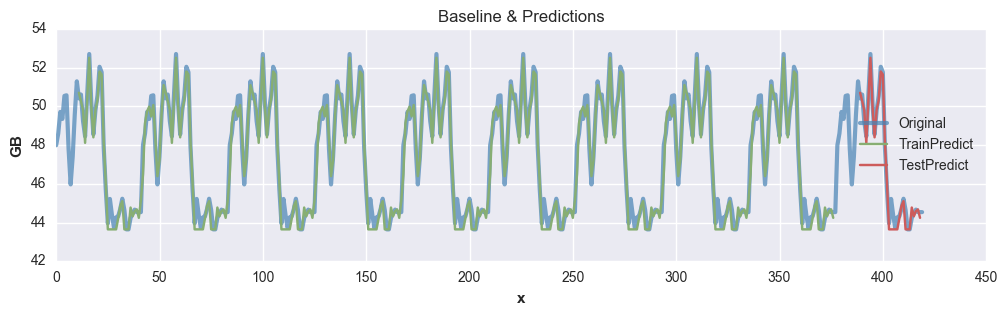

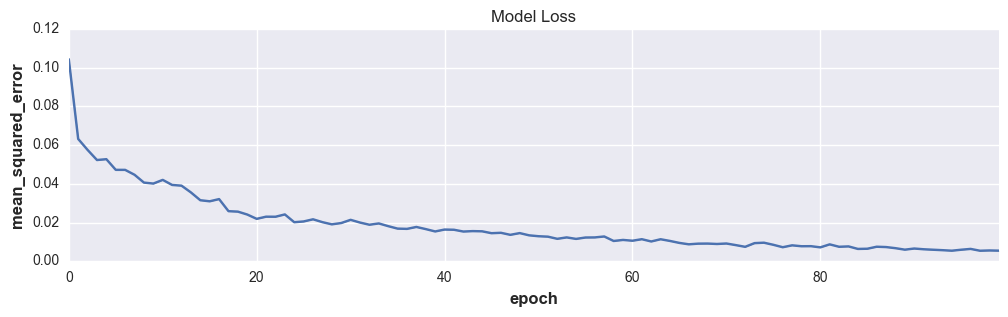

In [12]:
model, history = run_network(vdf8[['value']], layers = [1,50,100,1], 
                                lookback = 10, split_ratio=0.9, epochs=100)

plot_history(history)

### Multi-Step prediction...

In [232]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    prediction_seqs = []
    #for i in xrange(len(data)/prediction_len):
    #    curr_frame = data[i*prediction_len]
    for i in xrange(len(data)):
        curr_frame = data[i] 
        predicted = []
        for j in xrange(prediction_len):
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
            #print('i:%s, j: %s, cf: %s' %(i, j, curr_frame))
        prediction_seqs.append(predicted)
    return prediction_seqs

In [239]:
window_size = 10
prediction_len = 5

# load the dataset
dataset = vdf0[['value']]
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# reshape into X=t and Y=t+1
test = dataset[len(dataset) - window_size-2:len(dataset),:]
testX, testY = create_dataset(test, window_size)

# reshape input to be [samples, time steps, features]
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# predict the next few steps...
pds = predict_sequences_multiple(model, testX, window_size, prediction_len)

# denormalize the dataset
data = scaler.inverse_transform(pds)
print('Sequence: %s, testX: %s, testY: %s, pred: %s' % (look_back, testX.shape, testY.shape, data.shape))

# print results
df = pd.DataFrame(data)
df.head()

Sequence: 10, testX: (1L, 10L, 1L), testY: (1L,), pred: (1L, 5L)


,0,1,2,3,4
0,52.669437,57.149961,44.60961,44.347304,50.89804
